<a href="https://colab.research.google.com/github/ehtisham-Fazal/ACP_SRC/blob/main/ACP_LSTM_comibned_740%26240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACP-DA: Improving the Prediction of Anticancer Peptides Using Data Augmentation**

In [1]:
from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Activation, initializers, GRU, SimpleRNN
from keras.layers import LSTM, Dense, Dropout, Activation, GRU, SimpleRNN
from keras.callbacks import ModelCheckpoint,TensorBoard
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
# from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pickle
import scipy.io as sio
import numpy as np
from numpy import linalg as la
import argparse
!pip install wget
import wget

dataset_path='https://raw.githubusercontent.com/haichengyi/ACP-DL/master/acp240.txt'
wget.download(dataset_path, 'acp240.txt')
dataset_path='https://raw.githubusercontent.com/haichengyi/ACP-DL/master/acp740.txt'
wget.download(dataset_path, 'acp740.txt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=baa7d9c9651072d37af24cb64eec1ea77ed0f11b9f1c6913d2525c9a247e4457
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


'acp740.txt'

In [2]:
def TransDict_from_list(groups):
    transDict = dict()
    tar_list = ['0', '1', '2', '3', '4', '5', '6']
    result = {}
    index = 0
    for group in groups:
        g_members = sorted(group)  # Alphabetically sorted list
        for c in g_members:
            # print('c' + str(c))
            # print('g_members[0]' + str(g_members[0]))
            result[c] = str(tar_list[index])  # K:V map, use group's first letter as represent.
        index = index + 1
    return result

def get_3_protein_trids():
    nucle_com = []
    chars = ['0', '1', '2', '3', '4', '5', '6']
    base = len(chars)
    end = len(chars) ** 3
    for i in range(0, end):
        n = i
        ch0 = chars[n % base]
        n = n / base
        ch1 = chars[int(n % base)]
        n = n / base
        ch2 = chars[int(n % base)]
        nucle_com.append(ch0 + ch1 + ch2)
    return nucle_com

def translate_sequence(seq, TranslationDict):
    '''
    Given (seq) - a string/sequence to translate,
    Translates into a reduced alphabet, using a translation dict provided
    by the TransDict_from_list() method.
    Returns the string/sequence in the new, reduced alphabet.
    Remember - in Python string are immutable..
    '''
    import string
    from_list = []
    to_list = []
    for k, v in TranslationDict.items():
        from_list.append(k)
        to_list.append(v)
    # TRANS_seq = seq.translate(str.maketrans(zip(from_list,to_list)))
    TRANS_seq = seq.translate(str.maketrans(str(from_list), str(to_list)))
    # TRANS_seq = maketrans( TranslationDict, seq)
    return TRANS_seq

def get_4_nucleotide_composition(tris, seq, pythoncount=True):
    seq_len = len(seq)
    tri_feature = [0] * len(tris)
    k = len(tris[0])
    note_feature = [[0 for cols in range(len(seq) - k + 1)] for rows in range(len(tris))]
    if pythoncount:
        for val in tris:
            num = seq.count(val)
            tri_feature.append(float(num) / seq_len)
    else:
        # tmp_fea = [0] * len(tris)
        for x in range(len(seq) + 1 - k):
            kmer = seq[x:x + k]
            if kmer in tris:
                ind = tris.index(kmer)
                # tmp_fea[ind] = tmp_fea[ind] + 1
                note_feature[ind][x] = note_feature[ind][x] + 1
        # tri_feature = [float(val)/seq_len for val in tmp_fea]    #tri_feature type:list len:256
        u, s, v = la.svd(note_feature)
        for i in range(len(s)):
            tri_feature = tri_feature + u[i] * s[i] / seq_len
        # print tri_feature
        # pdb.set_trace()

    return tri_feature
# def get_4_nucleotide_composition(tris, seq, pythoncount=True):
#     seq_len = len(seq)
#     tri_feature = []
#
#     if pythoncount:
#         for val in tris:
#             num = seq.count(val)
#             tri_feature.append(float(num) / seq_len)
#     else:
#         k = len(tris[0])
#         tmp_fea = [0] * len(tris)
#         for x in range(len(seq) + 1 - k):
#             kmer = seq[x:x + k]
#             if kmer in tris:
#                 ind = tris.index(kmer)
#                 tmp_fea[ind] = tmp_fea[ind] + 1
#         tri_feature = [float(val) / seq_len for val in tmp_fea]
#         # pdb.set_trace()
#     return tri_feature

def prepare_feature_acp740():
    label = []
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 0
    with open('acp740.txt', 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]
                proteinName = values[0]
                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                protein_seq_dict[protein_index] = seq
                protein_index = protein_index + 1
    # name_list = read_name_from_lncRNA_fasta('ncRNA-protein/lncRNA_RNA.fa')
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()
    # tris3 = get_3_trids()
    bpf=[]
    kmer=[]
    # get protein feature
    # pdb.set_trace()
    for i in protein_seq_dict:  # and protein_fea_dict.has_key(protein) and RNA_fea_dict.has_key(RNA):
        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
        bpf_feature = BPF(protein_seq_dict[i])
        # print('bpf:',shape(bpf_feature))
        # pdb.set_trace()
        # RNA_tri_fea = get_4_nucleotide_composition(tris, RNA_seq, pythoncount=False)
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        bpf.append(bpf_feature)
        kmer.append(protein_tri_fea)
        # protein_index = protein_index + 1
        # chem_fea.append(chem_tmp_fea)
    return np.array(bpf), np.array(kmer), label

def prepare_feature_acp240():
    label = []
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 1
    with open('acp240.txt', 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]
                protein = values[0]
                if label_temp=='1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                protein_seq_dict[protein_index] = seq
                protein_index = protein_index + 1
    # name_list = read_name_from_lncRNA_fasta('ncRNA-protein/lncRNA_RNA.fa')
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()
    # tris3 = get_3_trids()
    bpf = []
    kmer = []
    # get protein feature
    # pdb.set_trace()
    for i in protein_seq_dict:  # and protein_fea_dict.has_key(protein) and RNA_fea_dict.has_key(RNA):

        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
        bpf_feature = BPF(protein_seq_dict[i])
        # print('bpf:',shape(bpf_feature))
        # pdb.set_trace()
        # RNA_tri_fea = get_4_nucleotide_composition(tris, RNA_seq, pythoncount=False)
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        bpf.append(bpf_feature)
        kmer.append(protein_tri_fea)
        protein_index = protein_index + 1
        # chem_fea.append(chem_tmp_fea)

    return np.array(bpf), np.array(kmer), label

def BPF(seq_temp):
    seq = seq_temp
    chars = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    fea = []
    tem_vec =[]
    k = 7
    for i in range(k):
        if seq[i] =='A':
            tem_vec = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='C':
            tem_vec = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='D':
            tem_vec = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='E':
            tem_vec = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='F':
            tem_vec = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='G':
            tem_vec = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='H':
            tem_vec = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='I':
            tem_vec = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='K':
            tem_vec = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='L':
            tem_vec = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='M':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='N':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
        elif seq[i]=='P':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
        elif seq[i]=='Q':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
        elif seq[i]=='R':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
        elif seq[i]=='S':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
        elif seq[i]=='T':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
        elif seq[i]=='V':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
        elif seq[i]=='W':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
        elif seq[i]=='Y':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
        fea = fea + tem_vec
    return fea

def prepare_feature():
    label = []
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 1
    with open('acp740.txt', 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]
                protein = values[0]
                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                protein_seq_dict[protein_index] = seq
                protein_index = protein_index + 1
    # name_list = read_name_from_lncRNA_fasta('ncRNA-protein/lncRNA_RNA.fa')
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()

    # tris3 = get_3_trids()
    train = []
    # get protein feature
    # pdb.set_trace()
    for i in protein_seq_dict:  # and protein_fea_dict.has_key(protein) and RNA_fea_dict.has_key(RNA):

        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
        # bpf_feature = BPF(protein_seq_dict[i])
        # pdb.set_trace()
        # RNA_tri_fea = get_4_nucleotide_composition(tris, RNA_seq, pythoncount=False)
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        train.append(protein_tri_fea)
        protein_index = protein_index + 1
        # chem_fea.append(chem_tmp_fea)

    return np.array(train), label
def calculate_performace(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn + 1
            else:
                fp = fp + 1

    acc = float(tp + tn) / test_num
    precision = float(tp) / (tp + fp)
    sensitivity = float(tp) / (tp + fn)
    specificity = float(tn) / (tn + fp)
    MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    return acc, precision, sensitivity, specificity, MCC

def transfer_label_from_prob(proba):
    label = [1 if val >= 0.5 else 0 for val in proba]
    return label
def plot_roc_curve(labels, probality, legend_text, auc_tag=True):
    # fpr2, tpr2, thresholds = roc_curve(labels, pred_y)
    fpr, tpr, thresholds = roc_curve(labels, probality)  # probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    if auc_tag:
        rects1 = plt.plot(fpr, tpr, label=legend_text + ' (AUC=%6.3f) ' % roc_auc)
    else:
        rects1 = plt.plot(fpr, tpr, label=legend_text)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 128)               313344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 full_connect (Dense)        (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 313,473
Trainable params: 313,473
Non-trainable params: 0
_________________________________________________________________
Compiling the Model...
Train...
Epoch 1/30
25/25 [==============================] - 3s 7ms/step - loss: 0.6792 - accuracy: 0.6250
Epoch 2/30
25/25 [==============================] - 

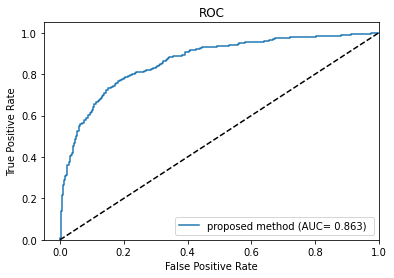

In [3]:
# define parameters
data_dim = 483
timesteps = 1
batch_size = 32   # if dataset = acp240, set batch_size = 32; if dataset = acp740, set batch_size = 64
epochs = 30
# get data
bpf_1, kmer_1, label_1 = prepare_feature_acp740()
bpf, kmer, label_2 = prepare_feature_acp240()
X = np.concatenate((bpf, kmer), axis=1)
y= np.concatenate((bpf_1, kmer_1), axis=1)
Datax=np.concatenate((X,y))
label=label_2+label_1
label=np.array(label)
# bpf_1, kmer_1, label_1 = prepare_feature_acp740()
# bpf, kmer, label = prepare_feature_acp240()
# X = np.concatenate((bpf, kmer), axis=1)
# 1 行拼接 0 默认，列拼接
#  expected input data shape: (batch_size, timesteps, data_dim)
X = np.reshape(Datax, (len(Datax), timesteps, data_dim))
# split data
# x_train, x_test, y_train, y_test = train_test_split(X, label, test_size=0.1, random_state=1024)
num_cross_val = 5  # 5-fold
all_performance_lstm = []
all_labels = []
all_prob = {}
num_classifier = 3
all_prob[0] = []
all_average = []

for fold in range(num_cross_val):
    # train = np.array([x for i, x in enumerate(bpf_fea) if i % num_cross_val != fold])
    # test = np.array([x for i, x in enumerate(bpf_fea) if i % num_cross_val == fold])
    # train = np.array([x for i, x in enumerate(kmer_fea) if i % num_cross_val != fold])
    # test = np.array([x for i, x in enumerate(kmer_fea) if i % num_cross_val == fold])
    train = np.array([x for i, x in enumerate(X) if i % num_cross_val != fold])
    test = np.array([x for i, x in enumerate(X) if i % num_cross_val == fold])
    train_label = np.array([x for i, x in enumerate(label) if i % num_cross_val != fold])
    test_label = np.array([x for i, x in enumerate(label) if i % num_cross_val == fold])
    real_labels = []
    for val in test_label:
        if val == 1:
            real_labels.append(1)
        else:
            real_labels.append(0)

    train_label_new = []
    for val in train_label:
        if val == 1:
            train_label_new.append(1)
        else:
            train_label_new.append(0)
    all_labels = all_labels + real_labels
    # init = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=64)

    model = Sequential()
    # model.add(Dense(200,input_shape=(200,1)))
    model.add(LSTM(128, return_sequences=False,input_shape=(timesteps, data_dim), name='lstm1'))  # returns a sequence of vectors of dimension 32
    #model.add(LSTM(32, return_sequences=True, name='lstm2'))  # returns a sequence of vectors of dimension 32
    #model.add(LSTM(8, return_sequences=True,name='lstm3'))  # returns a sequence of vectors of dimension 32
    #model.add(LSTM(3, return_sequences=False,name='lstm4'))  # return a single vector of dimension 32
    model.add(Dropout(0.25, name='dropout'))
    model.add(Dense(1, name='full_connect'))
    model.add(Activation('sigmoid'))
    model.summary()

    print('Compiling the Model...')
    model.compile(loss='binary_crossentropy',  #
          optimizer='adam',
          metrics=['accuracy'])

    print("Train...")

    model.fit(train, train_label, batch_size=batch_size,epochs=epochs)
    ####
    print(train.shape)
    print(test.shape)
    ####
    # lstm_proba = model.predict_proba(test)
    lstm_proba=model.predict(test)
    # lstm_proba=np.argmax(predict_prob,axis=1)

    all_prob[0] = all_prob[0] + [val for val in lstm_proba]
    y_pred_xgb = transfer_label_from_prob(lstm_proba)
    acc, precision, sensitivity, specificity, MCC = calculate_performace(len(real_labels), y_pred_xgb, real_labels)
    print(acc, precision, sensitivity, specificity, MCC)
    all_performance_lstm.append([acc, precision, sensitivity, specificity, MCC])
    print('---' * 50)

print('mean performance of ACP_DL')
print(np.mean(np.array(all_performance_lstm), axis=0))
print('---' * 50)

plot_roc_curve(all_labels, all_prob[0], 'proposed method')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
# plt.savefig(save_fig_dir + selected + '_' + class_type + '.png')
plt.show()


In [ ]:
Datax.shape

(980, 483)